This notebook demonstrates how to use KMeans clustering.

### Download Raw Data

In [7]:
url = 'https://opendata.arcgis.com/datasets/b9f0d3856802413dacd4e0c4523e7a5f_0.geojson'
raw_covid_data = requests.get(url).json()

### Data Preprocessing

Data preprocessing varies depending on the dataset used.

In [9]:
# Extract data from json, remove and rename some columns
data = pd.DataFrame([item['properties'] for item in raw_covid_data['features']])
data = data.drop(columns=['Notes', 'FID']).rename(columns={'Date': 'Timestamp'})
data.columns = [num.lstrip('Zip_') for num in data.columns]

# Make timestamps start at midnight, set index, no timezone
data['Timestamp'] = pd.to_datetime(data['Timestamp']).dt.normalize()
data = data.set_index('Timestamp').sort_index().tz_localize(None)

# Change cumulative case count to new case count
for col in data.columns:
    data[col] = data[col]-data[col].shift(1)
    data.loc[data[col] < 0, col] = 0

# Missing values become 0
data = data.fillna(0)

In [10]:
display(data)

,76574,78605,78610,78612,78613,78615,78616,78617,78620,78621,...,78749,78750,78751,78752,78753,78754,78756,78757,78758,78759
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-03-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-27,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0
2020-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2020-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-03-30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,2.0,0.0,4.0,0.0,0.0,10.0,4.0,0.0
2021-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,3.0,1.0
2021-05-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,...,0.0,0.0,0.0,10.0,1.0,2.0,0.0,0.0,1.0,2.0


### Build Features

In [11]:
# Transpose rows and columns for use in KMeans function
X1 = data.T

In [12]:
# The columns are features and the index is samples
display(X1)

Timestamp,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,...,2021-04-25,2021-04-26,2021-04-27,2021-04-28,2021-04-29,2021-04-30,2021-05-01,2021-05-02,2021-05-03,2021-05-04
76574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78610,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78613,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78754,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,5.0,2.0,1.0,2.0,0.0,5.0,2.0,1.0,4.0
78756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
78757,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,8.0,...,8.0,1.0,0.0,3.0,0.0,10.0,0.0,0.0,11.0,0.0
78758,0.0,0.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,28.0,...,4.0,4.0,6.0,0.0,6.0,4.0,3.0,1.0,0.0,3.0


### Fit model and show results

In [14]:
from sklearn.cluster import KMeans

# You choose the number of clusters and then fit with KMeans
model = KMeans(n_clusters=3).fit(X1)

In [32]:
# This shows what cluster was assigned to each sample, it is just array that follows the order of X1's index
model.labels_

# Here we make the labels more understandable
labels = pd.DataFrame(model.labels_).rename(columns={0:'cluster'})
labels.index = X1.index
display(labels)

,cluster
76574,0
78605,0
78610,0
78612,0
78613,0
...,...
78754,2
78756,0
78757,0
78758,1


[[0.         0.67272727 0.12727273 ... 0.49090909 0.87272727 0.30909091]
 [0.         0.8        1.         ... 1.4        4.6        2.        ]
 [0.         0.72727273 0.63636364 ... 3.27272727 1.90909091 3.27272727]]


,0,1,2
0,0.000000,0.0,0.000000
1,0.672727,0.8,0.727273
2,0.127273,1.0,0.636364
3,0.200000,0.6,0.363636
4,0.200000,1.8,0.636364
...,...,...,...
400,0.909091,6.0,1.454545
401,0.327273,3.6,2.272727
402,0.490909,1.4,3.272727
403,0.872727,4.6,1.909091


<AxesSubplot:>

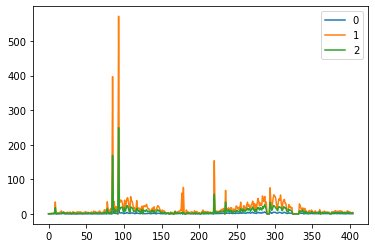

In [31]:
# The cluster_centers_ method shows the centroid of each cluster, the data points that mak
print(model.cluster_centers_)

# Put it into a dataframe
df = pd.DataFrame(model.cluster_centers_).T
display(df)

# And plot it
df.plot()